Main resource: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

In [1]:
import flair
import numpy as np
import pandas as pd
import torch
from torch.optim.adam import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flair.device = device

print(flair.device)

cuda


In [2]:
print(torch.__version__)

1.7.1+cu110


In [3]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerDocumentEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

data_folder = '../data/corpuslow_13042021'
column_name_map = {1: "text", 2: "label_topic"}

# 1. get the corpus
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True) 

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

print(label_dict)

2021-04-26 21:38:14,657 Reading data from ..\data\corpuslow_13042021
2021-04-26 21:38:14,658 Train: ..\data\corpuslow_13042021\train.csv
2021-04-26 21:38:14,658 Dev: ..\data\corpuslow_13042021\dev.csv
2021-04-26 21:38:14,658 Test: ..\data\corpuslow_13042021\test.csv
2021-04-26 21:38:14,675 Computing label dictionary. Progress:


100%|██████████████████████████████████████████████████████████████████████████████████| 976/976 [00:01<00:00, 850.00it/s]

2021-04-26 21:38:33,355 [b'0', b'1']
Dictionary with 2 tags: 0, 1


In [4]:
# 4. initialize document embedding by passing list of word embeddings
document_embeddings = TransformerDocumentEmbeddings('roberta-base', fine_tune=True)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# 7. start the training
trainer.train('./flair/roberta_low',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=4,
              mini_batch_chunk_size=2, # optionally set this if transformer is too much for your machine
              max_epochs=10, # terminate after 10 epochs)
              train_with_dev=True,
              patience=3,
              monitor_test=True,
              embeddings_storage_mode='gpu') 

2021-04-26 21:38:44,158 ----------------------------------------------------------------------------------------------------
2021-04-26 21:38:44,161 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_feature

{'test_score': 0.6789,
 'dev_score_history': [],
 'train_loss_history': [0.7430794527181653,
  0.7099161465178991,
  0.7052312773637107,
  0.6371348528954827,
  0.6569477982941221,
  0.6643175768864448,
  0.6464868303327287,
  0.6232670636572799,
  0.6443140923244054,
  0.6295505785612298],
 'dev_loss_history': []}

2021-04-26 21:49:38,325 ----------------------------------------------------------------------------------------------------
2021-04-26 21:49:38,326 WARNING: No F1 found for test split in this data.
2021-04-26 21:49:38,326 Are you sure you want to plot F1 and not another value?
2021-04-26 21:49:38,327 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


Loss and F1 plots are saved in flair\roberta_low\training.png


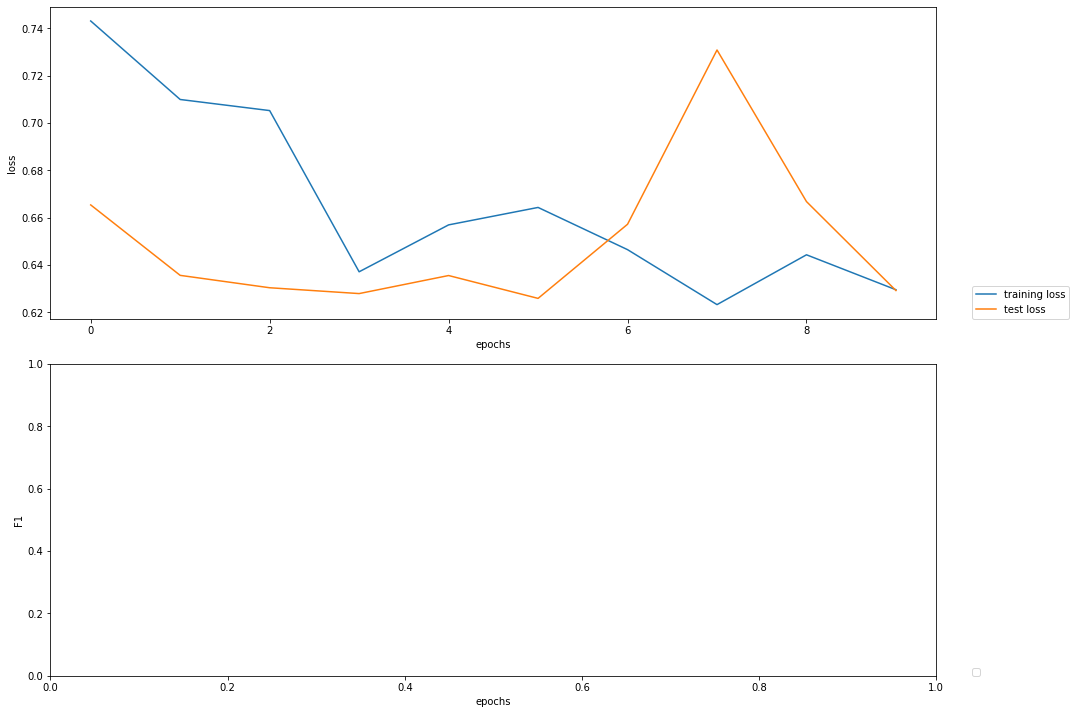

In [5]:
# visualize
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./flair/roberta_low/loss.tsv')

#This generates PNG plots in the result folder.

In [6]:
test_csv = pd.read_csv('../data/corpuslow_13042021/test.csv')
test_csv.head()

,Unnamed: 0,Response,LowConcrete
0,1000,"1. Phone old friends\n2. Text, video call fami...",1
1,446,Getting back to my activities would be great. ...,0
2,608,I would make a list (mental or on paper) of wh...,0
3,457,Mostly I would paint and play/compose music wh...,1
4,149,"Lately I have been feeling lonely ,, the steps...",0


In [7]:
from flair.data import Sentence

test_data = []
target = []
preds = []

for i, item in test_csv.iterrows():
    test_data.append(Sentence(item.Response))
    target.append(str(item.LowConcrete))
    
classifier.predict(test_data, mini_batch_size=4)

for item in test_data:
    preds.append(item.labels[0].value)

C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['1', '0'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

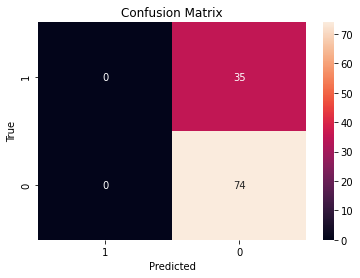

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['1', '0']
cm = confusion_matrix(target, preds, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(target,preds))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        74
           1       0.00      0.00      0.00        35

    accuracy                           0.68       109
   macro avg       0.34      0.50      0.40       109
weighted avg       0.46      0.68      0.55       109



C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
